# Finite Volume Discretisation

In this notebook, we explain the discretisation process that converts an expression tree, representing a model, to a linear algebra tree that can be evaluated by the solvers. 

We use Finite Volumes as an example of a spatial method, since it is the default spatial method for most PyBaMM models. This is a good spatial method for battery problems as it is conservative: for lithium-ion battery models, we can be sure that the total amount of lithium in the system is constant. For more details on the Finite Volume method, see [Randall Leveque's book](https://books.google.co.uk/books/about/Finite_Volume_Methods_for_Hyperbolic_Pro.html?id=QazcnD7GUoUC&printsec=frontcover&source=kp_read_button&redir_esc=y#v=onepage&q&f=false).

This notebook is structured as follows:

1. **Setting up a discretisation**. Overview of the parameters that are passed to the discretisation
2. **Discretisations and spatial methods**. Operations that are common to most spatial methods:
    - Discretising a spatial variable (e.g. $x$)
    - Discretising a variable (e.g. concentration)
3. **Example: Finite Volume operators**. Finite Volume implementation of some useful operators: 
    - Gradient operator
    - Divergence operator
    - Integral operator
4. **Example: Discretising a simple model**. Setting up and solving a simple model, using Finite Volumes as the spatial method

To find out how to implement a new spatial method, see the [tutorial](https://pybamm.readthedocs.io/en/latest/tutorials/add-spatial-method.html) in the API docs.

## Setting up a Discretisation

We first import `pybamm` and some useful other modules, and change our working directory to the root of the `PyBaMM` folder:

In [1]:
import pybamm
import numpy as np
import os
import matplotlib.pyplot as plt
from pprint import pprint
os.chdir(pybamm.__path__[0]+'/..')

To set up a discretisation, we must create a geometry, mesh this geometry, and then create the discretisation with the appropriate spatial method(s). The easiest way to create a geometry is to use an inbuilt one:

In [2]:
parameter_values = pybamm.ParameterValues(
    values={
        "Negative electrode thickness [m]": 0.3,
        "Separator thickness [m]": 0.2,
        "Positive electrode thickness [m]": 0.3,
    }
)

geometry = pybamm.Geometry("1D macro", "1D micro")
parameter_values.process_geometry(geometry)

We then use this geometry to create a mesh, which for this example consists of uniform 1D submeshes

In [3]:
submesh_types = {
    "negative electrode": pybamm.Uniform1DSubMesh,
    "separator": pybamm.Uniform1DSubMesh,
    "positive electrode": pybamm.Uniform1DSubMesh,
    "negative particle": pybamm.Uniform1DSubMesh,
    "positive particle": pybamm.Uniform1DSubMesh,
    "current collector": pybamm.SubMesh0D,
}

var = pybamm.standard_spatial_vars
var_pts = {var.x_n: 15, var.x_s: 10, var.x_p: 15, var.r_n: 10, var.r_p: 10}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

Finally, we can use the mesh to create a discretisation, using Finite Volumes as the spatial method for this example

In [4]:
spatial_methods = {
    "macroscale": pybamm.FiniteVolume(),
    "negative particle": pybamm.FiniteVolume(),
    "positive particle": pybamm.FiniteVolume(),
}
disc = pybamm.Discretisation(mesh, spatial_methods)

## Discretisations and Spatial Methods

### Spatial Variables

Spatial variables, such as $x$ and $r$, are converted to `pybamm.Vector` nodes

x_disc is a <class 'pybamm.expression_tree.vector.Vector'>
r_disc is a <class 'pybamm.expression_tree.vector.Vector'>


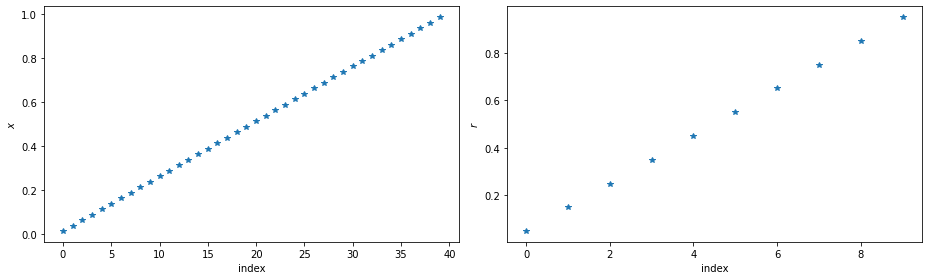

In [5]:
# Set up 
macroscale = ["negative electrode", "separator", "positive electrode"]
x_var = pybamm.SpatialVariable("x", domain=macroscale)
r_var = pybamm.SpatialVariable("r", domain=["negative particle"])

# Discretise
x_disc = disc.process_symbol(x_var)
r_disc = disc.process_symbol(r_var)
print("x_disc is a {}".format(type(x_disc)))
print("r_disc is a {}".format(type(r_disc)))

# Evaluate
x = x_disc.evaluate()
r = r_disc.evaluate()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))

ax1.plot(x, "*")
ax1.set_xlabel("index")
ax1.set_ylabel(r"$x$")

ax2.plot(r, "*")
ax2.set_xlabel("index")
ax2.set_ylabel(r"$r$")

plt.tight_layout()
plt.show()

We define `y_macroscale`, `y_microscale` and `y_scalar` for evaluation and visualisation of results below

In [6]:
y_macroscale = x ** 3 / 3
y_microscale = np.cos(r)
y_scalar = np.array([[5]])

y = np.concatenate([y_macroscale, y_microscale, y_scalar])

### Variables

In this notebook, we will work with three variables `u`, `v`, `w`.

In [7]:
u = pybamm.Variable("u", domain=macroscale) # u is a variable in the macroscale (e.g. electrolyte potential)
v = pybamm.Variable("v", domain=["negative particle"]) # v is a variable in the negative particle (e.g. particle concentration)
w = pybamm.Variable("w") # w is a variable without a domain (e.g. time, average concentration)

variables = [u,v,w]

Before discretising, trying to evaluate the variables raises a `NotImplementedError`:

In [8]:
try:
    u.evaluate()
except NotImplementedError as e: 
    print(e)

method self.evaluate() not implemented
               for symbol u of type <class 'pybamm.expression_tree.variable.Variable'>


For any spatial method, a `pybamm.Variable` gets converted to a `pybamm.StateVector` which, when evaluated, takes the appropriate slice of the input vector `y`. 

In [9]:
# Pass the list of variables to the discretisation to calculate the slices to be used (order matters here!)
disc.set_variable_slices(variables)

# Discretise the variables
u_disc = disc.process_symbol(u)
v_disc = disc.process_symbol(v)
w_disc = disc.process_symbol(w)

# Print the outcome 
print("Discretised u is the StateVector {}".format(u_disc))
print("Discretised v is the StateVector {}".format(v_disc))
print("Discretised w is the StateVector {}".format(w_disc))

Discretised u is the StateVector y[0:40]
Discretised v is the StateVector y[40:50]
Discretised w is the StateVector y[50:51]


Since the variables have been passed to `disc` in the order `[u,v,w]`, they each read the appropriate part of `y` when evaluated:

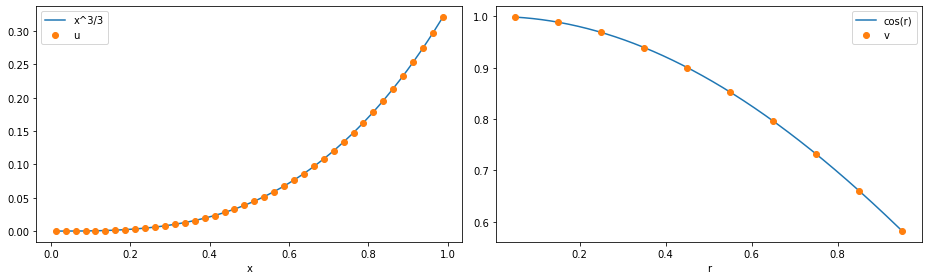

In [10]:
x_fine = np.linspace(x[0], x[-1], 1000)
r_fine = np.linspace(r[0], r[-1], 1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
ax1.plot(x_fine, x_fine**3/3, x, u_disc.evaluate(y=y), "o")
ax1.set_xlabel("x")
ax1.legend(["x^3/3", "u"], loc="best")

ax2.plot(r_fine, np.cos(r_fine), r, v_disc.evaluate(y=y), "o")
ax2.set_xlabel("r")
ax2.legend(["cos(r)", "v"], loc="best")

plt.tight_layout()
plt.show()

In [11]:
print("w = {}".format(w_disc.evaluate(y=y)))

w = [[5.]]


## Finite Volume Operators

### Gradient operator

The gradient operator is converted to a Matrix-StateVector multiplication. In 1D, the gradient operator is equivalent to $\partial/\partial x$ on the macroscale and $\partial/\partial r$ on the microscale. In Finite Volumes, we take the gradient of an object on nodes (shape (n,)), which returns an object on the edges (shape (n-1,)). 

In [12]:
grad_u = pybamm.grad(u)
grad_u_disc = disc.process_symbol(grad_u)
grad_u_disc.render()

@
├── Sparse Matrix (39, 40)
└── y[0:40]


The Matrix in `grad_u_disc` is the standard `[-1,1]` sparse matrix, divided by the step sizes `dx`:

In [13]:
macro_mesh = mesh.combine_submeshes(*macroscale)[0]
print("gradient matrix is:\n")
print("1/dx *\n{}".format(macro_mesh.d_nodes[:,np.newaxis] * grad_u_disc.children[0].entries.toarray()))

gradient matrix is:

1/dx *
[[-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ...  0. -1.  1.]]


When evaluated with `y_macroscale=x**3/3`, `grad_u_disc` is equal to `x**2` as expected:

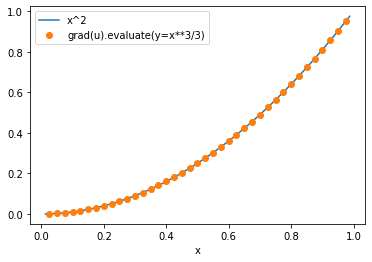

In [14]:
x_edge = macro_mesh.edges[1:-1] # note that grad_u_disc is evaluated on the node edges

fig, ax = plt.subplots()
ax.plot(x_fine, x_fine**2, x_edge, grad_u_disc.evaluate(y=y), "o")
ax.set_xlabel("x")
legend = ax.legend(["x^2", "grad(u).evaluate(y=x**3/3)"], loc="best")

plt.show()

Similary, we can create, discretise and evaluate the gradient of `v`, which is a variable in the negative particles. Note that the syntax for doing this is identical: we do not need to explicitly specify that we want the gradient in `r`, since this is inferred from the `domain` of `v`.

In [15]:
v.domain

['negative particle']

grad(v) tree is:

@
├── Sparse Matrix (9, 10)
└── y[40:50]

 gradient matrix is:

1/dr *
[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.]]


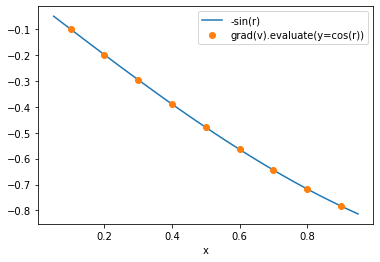

In [16]:
grad_v = pybamm.grad(v)
grad_v_disc = disc.process_symbol(grad_v)
print("grad(v) tree is:\n")
grad_v_disc.render()

micro_mesh = mesh["negative particle"][0]
print("\n gradient matrix is:\n")
print("1/dr *\n{}".format(micro_mesh.d_nodes[:,np.newaxis] * grad_v_disc.children[0].entries.toarray()))

r_edge = micro_mesh.edges[1:-1] # note that grad_u_disc is evaluated on the node edges

fig, ax = plt.subplots()
ax.plot(r_fine, -np.sin(r_fine), r_edge, grad_v_disc.evaluate(y=y), "o")
ax.set_xlabel("x")
legend = ax.legend(["-sin(r)", "grad(v).evaluate(y=cos(r))"], loc="best")

plt.show()

#### Boundary conditions

If the discretisation is provided with boundary conditions, appropriate ghost nodes are concatenated onto the variable, and a larger gradient matrix is used. The ghost nodes are chosen based on the value of the first/last node in the variable and the boundary condition.
For a Dirichlet boundary condition $u=a$ on the left-hand boundary, we set the value of the left ghost node to be equal to
$$2*a-u[0],$$
where $u[0]$ is the value of $u$ in the left-most cell in the domain. Similarly, for a Dirichlet condition $u=b$ on the right-hand boundary, we set the right ghost node to be
$$2*b-u[-1].$$
Note also that the size of the gradient matrix is now (41,42) instead of (39,40), to account for the presence of boundary conditions in the State Vector.

In [17]:
disc.bcs = {u.id: {"left": (pybamm.Scalar(1), "Dirichlet"), "right": (pybamm.Scalar(2), "Dirichlet")}}
grad_u_disc = disc.process_symbol(grad_u)
print("The gradient object is:")
(grad_u_disc.render())
u_eval = grad_u_disc.children[1].evaluate(y=y)
print("The value of u on the left-hand boundary is {}".format((u_eval[0] + u_eval[1]) / 2))
print("The value of u on the right-hand boundary is {}".format((u_eval[-2] + u_eval[-1]) / 2))

The gradient object is:
@
├── Sparse Matrix (41, 42)
└── +
    ├── @
    │   ├── Sparse Matrix (42, 40)
    │   └── y[0:40]
    └── Column vector of length 42
The value of u on the left-hand boundary is [1.]
The value of u on the right-hand boundary is [2.]


For a Neumann boundary condition $\partial u/\partial x=c$ on the left-hand boundary, we set the value of the left ghost node to be
$$u[0] - c * dx,$$
where $dx$ is the step size at the left-hand boundary. For a Neumann boundary condition $\partial u/\partial x=d$ on the right-hand boundary, we set the value of the right ghost node to be
$$u[-1] + d * dx.$$

In [18]:
disc.bcs = {u.id: {"left": (pybamm.Scalar(3), "Neumann"), "right": (pybamm.Scalar(4), "Neumann")}}
grad_u_disc = disc.process_symbol(grad_u)
print("The gradient object is:")
(grad_u_disc.render())
grad_u_eval = grad_u_disc.evaluate(y=y)
print("The gradient on the left-hand boundary is {}".format(grad_u_eval[0]))
print("The gradient of u on the right-hand boundary is {}".format(grad_u_eval[-1]))

The gradient object is:
+
├── @
│   ├── Sparse Matrix (41, 39)
│   └── @
│       ├── Sparse Matrix (39, 40)
│       └── y[0:40]
└── Column vector of length 41
The gradient on the left-hand boundary is [3.]
The gradient of u on the right-hand boundary is [4.]


We can mix the types of the boundary conditions:

In [19]:
disc.bcs = {u.id: {"left": (pybamm.Scalar(5), "Dirichlet"), "right": (pybamm.Scalar(6), "Neumann")}}
grad_u_disc = disc.process_symbol(grad_u)
print("The gradient object is:")
(grad_u_disc.render())
grad_u_eval = grad_u_disc.evaluate(y=y)
u_eval = grad_u_disc.children[1].evaluate(y=y)
print("The value of u on the left-hand boundary is {}".format((u_eval[0] + u_eval[1])/2))
print("The gradient on the right-hand boundary is {}".format(grad_u_eval[-1]))

The gradient object is:
+
├── @
│   ├── Sparse Matrix (41, 40)
│   └── @
│       ├── Sparse Matrix (40, 41)
│       └── +
│           ├── @
│           │   ├── Sparse Matrix (41, 40)
│           │   └── y[0:40]
│           └── Column vector of length 41
└── Column vector of length 41
The value of u on the left-hand boundary is [0.]
The gradient on the right-hand boundary is [6.]


Robin boundary conditions are not yet implemented.

### Divergence operator

Before computing the Divergence operator, we set up Neumann boundary conditions. The behaviour with Dirichlet boundary conditions is very similar.

In [20]:
disc.bcs = {u.id: {"left": (pybamm.Scalar(-1), "Neumann"), "right": (pybamm.Scalar(1), "Neumann")}}

Now we can process `div(grad(u))`, converting it to a Matrix-Vector multiplication, plus a vector for the boundary conditions. Since we have Neumann boundary conditions, the divergence of an object of size (n,) has size (n+1,).

In [21]:
div_grad_u = pybamm.div(grad_u)
div_grad_u_disc = disc.process_symbol(div_grad_u)
div_grad_u_disc.render()

@
├── Sparse Matrix (40, 41)
└── +
    ├── @
    │   ├── Sparse Matrix (41, 39)
    │   └── @
    │       ├── Sparse Matrix (39, 40)
    │       └── y[0:40]
    └── Column vector of length 41


Once again, in 1D, the divergence matrix is a `[-1,1]` matrix (divided by the distance between the edges)

In [22]:
print("divergence matrix is:\n")
print("1/dx * \n{}".format(
    macro_mesh.d_edges[:,np.newaxis] * div_grad_u_disc.children[0].entries.toarray()
))

divergence matrix is:

1/dx * 
[[-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ...  0. -1.  1.]]


We can simplify `div_grad_u_disc`, to collapse the two `[-1,1]` matrices into a single `[1,-2,1]` matrix. The vector of boundary conditions is also simplified.

In [23]:
div_grad_u_disc_simp = div_grad_u_disc.simplify()
div_grad_u_disc_simp.render()

@
├── Sparse Matrix (40, 41)
└── +
    ├── Column vector of length 41
    └── @
        ├── Sparse Matrix (41, 40)
        └── y[0:40]


In [24]:
print("laplacian matrix is:\n")
print("1/dx^2 *\n{}".format(
    macro_mesh.d_edges[:,np.newaxis] ** 2 * div_grad_u_disc_simp.children[0].entries.toarray()
))

laplacian matrix is:

1/dx^2 *
[[-0.025  0.025  0.    ...  0.     0.     0.   ]
 [ 0.    -0.025  0.025 ...  0.     0.     0.   ]
 [ 0.     0.    -0.025 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  0.025  0.     0.   ]
 [ 0.     0.     0.    ... -0.025  0.025  0.   ]
 [ 0.     0.     0.    ...  0.    -0.025  0.025]]


Simplifying the tree reduces the time taken to evaluate it:

In [25]:
import timeit
timeit.timeit('div_grad_u_disc.evaluate(y=y)', setup="from __main__ import div_grad_u_disc, y", number=10000)

0.35892684799999586

In [26]:
timeit.timeit('div_grad_u_disc_simp.evaluate(y=y)', setup="from __main__ import div_grad_u_disc_simp, y", number=10000)

0.2939778999999998

### Integral operator

Finally, we can define an integral operator, which integrates the variable across the domain specified by the integration variable.

In [27]:
int_u = pybamm.Integral(u, x_var)
int_u_disc = disc.process_symbol(int_u)
print("int(u) = {} is approximately equal to 1/12, {}".format(int_u_disc.evaluate(y=y), 1/12))

# We divide v by r to evaluate the integral more easily
int_v_over_r = pybamm.Integral(v/r_var, r_var)
int_v_over_r_disc = disc.process_symbol(int_v_over_r)
print("int(v/r) = {} is approximately equal to 4 * pi**2 * sin(1), {}".format(
    int_v_over_r_disc.evaluate(y=y), 4 * np.pi**2 * np.sin(1))
)

int(u) = [[0.08330729]] is approximately equal to 1/12, 0.08333333333333333
int(v/r) = [[33.23378862]] is approximately equal to 4 * pi**2 * sin(1), 33.21994294019605


The integral operators are also Matrix-Vector multiplications

In [28]:
print("int(u):\n")
int_u_disc.render()
print("\nint(v):\n")
int_v_over_r_disc.render()

int(u):

@
├── Sparse Matrix (1, 40)
└── y[0:40]

int(v):

@
├── Sparse Matrix (1, 10)
└── *
    ├── /
    │   ├── y[40:50]
    │   └── Column vector of length 10
    └── Column vector of length 10


In [29]:
int_u_disc.children[0].evaluate() / macro_mesh.d_edges

matrix([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.]])

In [30]:
int_v_over_r_disc.children[0].evaluate() / micro_mesh.d_edges

matrix([[39.4784176, 39.4784176, 39.4784176, 39.4784176, 39.4784176,
         39.4784176, 39.4784176, 39.4784176, 39.4784176, 39.4784176]])

## Discretising a model

We can now discretise a whole model. We create, and discretise, a simple model for the concentration in the electrolyte and the concentration in the particles, and discretise it with a single command:
```
disc.process_model(model)
```

In [31]:
model = pybamm.BaseModel()

c_e = pybamm.Variable("electrolyte concentration", domain=macroscale)
N_e = pybamm.grad(c_e)
c_s = pybamm.Variable("particle concentration", domain=["negative particle"])
N_s = pybamm.grad(c_s)
model.rhs = {c_e: pybamm.div(N_e) - 5, c_s: pybamm.div(N_s)}
model.boundary_conditions = {
    c_e: {"left": (np.cos(0), "Neumann"), "right": (np.cos(10), "Neumann")},
    c_s: {"left": (0, "Neumann"), "right": (-1, "Neumann")},
}
model.initial_conditions = {c_e: 1 + 0.1 * pybamm.sin(10*x_var), c_s: 1}

# Create a new discretisation and process model
disc2 = pybamm.Discretisation(mesh, spatial_methods)
disc2.process_model(model);

The initial conditions are discretised to vectors, and an array of concatenated initial conditions is created.

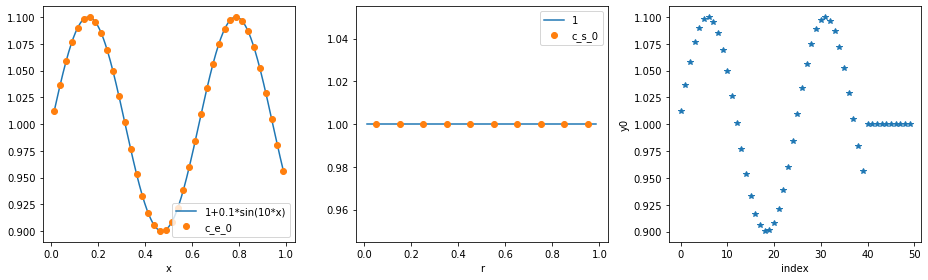

In [32]:
c_e_0 = model.initial_conditions[c_e].evaluate()
c_s_0 = model.initial_conditions[c_s].evaluate()
y0 = model.concatenated_initial_conditions.evaluate()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,4))
ax1.plot(x_fine, 1 + 0.1*np.sin(10*x_fine), x, c_e_0, "o")
ax1.set_xlabel("x")
ax1.legend(["1+0.1*sin(10*x)", "c_e_0"], loc="best")

ax2.plot(x_fine, np.ones_like(r_fine), r, c_s_0, "o")
ax2.set_xlabel("r")
ax2.legend(["1", "c_s_0"], loc="best")

ax3.plot(y0,"*")
ax3.set_xlabel("index")
ax3.set_ylabel("y0")

plt.tight_layout()
plt.show()

The discretised rhs can be evaluated, for example at `0,y0`:

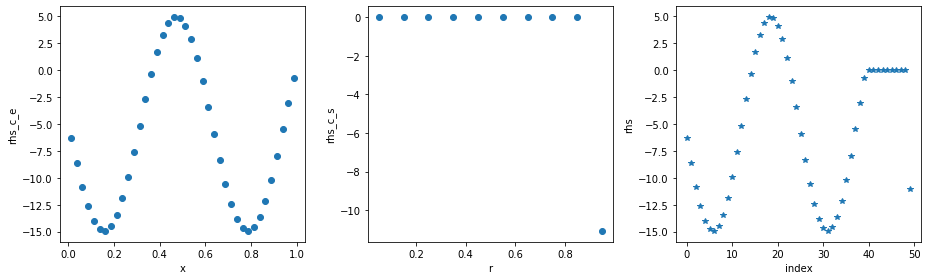

In [33]:
rhs_c_e = model.rhs[c_e].evaluate(0, y0)
rhs_c_s = model.rhs[c_s].evaluate(0, y0)
rhs = model.concatenated_rhs.evaluate(0, y0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,4))
# ax1.plot(x_fine, -10*np.sin(10*x_fine) - 5, x, rhs_c_e, "o")
ax1.plot(x, rhs_c_e, "o")
ax1.set_xlabel("x")
ax1.set_ylabel("rhs_c_e")
# ax1.legend(["1+0.1*sin(10*x)", "c_e_0"], loc="best")

ax2.plot(r, rhs_c_s, "o")
ax2.set_xlabel("r")
ax2.set_ylabel("rhs_c_s")

ax3.plot(rhs,"*")
ax3.set_xlabel("index")
ax3.set_ylabel("rhs")

plt.tight_layout()
plt.show()

The function `model.concatenated_rhs` is then passed to the solver to solve the model, with initial conditions `model.concatenated_initial_conditions`.

## More advanced concepts

Since this notebook is only an introduction to the discretisation, we have not covered everything. More advanced concepts, such as the ones below, can be explored by looking into the [API docs](https://pybamm.readthedocs.io/en/latest/source/spatial_methods/finite_volume.html).

- Gradient and divergence of microscale variables in the P2D model
- Indefinite integral

If you would like detailed examples of these operations, please [create an issue](https://github.com/pybamm-team/PyBaMM/blob/master/CONTRIBUTING.md#a-before-you-begin) and we will be happy to help.